November: Implements improvements to the basic bathymetry originally developed in make_mackenzie.ipynb.

In [24]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_idealized

# Load

Since this notebook's purpose is just to compare bathymetries, I've shortened the procedure so all you need to enter is the values for x/ysize and x/y_wall and the canyon dimensions in make_topo_smooth. You can get the former values from print statements in final_bathymetry.

Load the realistic bathymetry against which you're comparing the idealized bathymetry, preferably one with the same size so the resolution features match up.

In [25]:
xsize, ysize, x_wall, y_wall = 238, 178, 547219.33445374772, 406382.26879306574

real_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/realistic/real_bathy_02.nc')
z_real = real_file['Bathymetry'][:]

# Original - preFebruary

In [26]:
x_wall, y_wall, w_break, w_mid, w_head, width_f, cR, L, y_coast, y_head, y_break, y_paral, y_base,\
fluid_depth, z_bottom, z_paral, z_break, z_coast, p = functions_idealized.Mackenzie_measurements(x_wall, y_wall)

x, y, y_edge, X, Y = functions_idealized.set_domain_grid(xsize, ysize, x_wall, y_wall)

z_ideal_orig = functions_idealized.make_topo_smooth(y_edge, y_base, y_paral, y_break, y_head, y_coast, cR, L,
                                               x, x_wall, w_break, w_mid, w_head, p,
                                               fluid_depth, z_bottom, z_paral, z_break, z_coast)

# Idealized bathymetry functions

Functions are modified from the original make_mackenzie notebook. I work on the function's new versions here and then copy them to functions_idealized.py. This includes the way that y's are calculated using the total size of the domain. The values for y are calculated by finding the distance between the southern wall of the domain and the feature and then subtracting it from the total y_wall distance.

What I've observed is that changing the mid width does nothing if you don't give it room to expand by changing the w_head and w_break. Also removing the squared from the first elif gives a U shaped canyon instead of a gradual gaussian. Changing the mid width doesn't do much if you don't change the head width. Changing the head width and leaving the break width constant is the best way to go because the mid width adjusts and the break remains in the same place (doesn't expand).

In [84]:
def base_measurements():
    x_wall, y_wall = 438772.15043801494, 325034.36404318013
    fluid_depth = 1300.0
    return x_wall, y_wall, fluid_depth

def extended_measurements(lon_s_grid, lat_s_grid):
    p_NE = [lon_s_grid[-1,-1], lat_s_grid[-1,-1]]
    p_SE = [lon_s_grid[-1,0], lat_s_grid[-1,0]]
    p_SW = [lon_s_grid[0,0], lat_s_grid[0,0]]
    x_wall = functions_grid.find_distance(p_SW, p_SE)
    y_wall = functions_grid.find_distance(p_NE, p_SE)
    return x_wall, y_wall

def Mackenzie_measurements(x_wall, y_wall):
    
    ''' This function defines all measurements made
    for Mackenzie Canyon that are used to create 
    the idealized bathymetry profile.
    '''
    
    # Distances
    wall_coast = 26627.0539114
    wall_head = 48259.7140481
    wall_pointA = 133268.525917 #new
    wall_pointB = 111635.567809 #new
    wall_paral = 167520.894219 
    wall_base = 174731.93755
    L = 98000#93744.3331621#
    
    # Alongshore
    w_break = 62681.735776859277  
    w_mid = 46456.969337226466  
    w_head = 36000#14142.13562373095 
    width_f = 62681.735776859277

    # Cross-shore
    cR = 9246.0  
    y_coast = y_wall - wall_coast
    y_head = y_wall - wall_head
    y_break = (y_wall - wall_head) - L
    y_pointA = (y_wall - wall_pointA) #new
    y_pointB = (y_wall - wall_pointB) #new
    y_paral = y_wall - wall_paral
    y_base = y_wall - wall_base
    
    # Depths
    p = 4.0
    fluid_depth = 1300.0
    z_bottom = fluid_depth - fluid_depth
    z_paral = fluid_depth - 825.0
    z_pointA = fluid_depth - 379 #new
    z_pointB = fluid_depth - 258 #new
    z_break = fluid_depth - 80.0
    z_coast = fluid_depth - 40.0 #changed from 40 to 0 for open boundaries dec15
    
    return x_wall, y_wall, w_break, w_mid, w_head, width_f,\
    cR, L, y_coast, y_head, y_break, y_pointA, y_pointB, y_paral, y_base,\
    fluid_depth, z_bottom, z_paral, z_pointA, z_pointB, z_break, z_coast, p

# ------------------------------------------------------------------------------------

def set_domain_grid(xsize, ysize, x_wall, y_wall):
    
    ''' Sets up the domain dimensions and grid cells used
    to generate the canyon bathymetry.
    
    :arg xsize: X direction dimension (alongshore)
    :arg ysize: Y direction dimension (cross-shore)
    '''
    
    xgrd_all = np.arange(0, xsize, 1)
    xgrd_bounds = [0, xsize-1]
    xval_bounds = [0, x_wall]
    xval_all = np.interp(xgrd_all, xgrd_bounds, xval_bounds)
    x_edge = np.zeros(xsize)
    x_edge[:] = xval_all[:]
    x = ((x_edge[1:] + x_edge[0:-1])/2)

    ygrd_all = np.arange(0, ysize, 1)
    ygrd_bounds = [0, ysize-1]
    yval_bounds = [0, y_wall]
    yval_all = np.interp(ygrd_all, ygrd_bounds, yval_bounds)
    y_edge = np.zeros(ysize)
    y_edge[:] = yval_all[:]
    y = ((y_edge[1:] + y_edge[0:-1])/2)

    X, Y = np.meshgrid(x, y)
    
    return x, y, y_edge, X, Y

# ------------------------------------------------------------------------------------

def tanktopo(y, y_base, y_break, y_coast,
             fluid_depth, z_bottom, z_break, z_coast):
    
    ''' This function generates the topographical profile of the continental
    slope and shelf without the canyon. The profile is created in parts using
    the equation of a line: topography = z2 = (m * y2) - (m* y1) + z1, where
    the values for y represent key distances along the cross-shore direction
    and the values for z2 are the calculated depths based on a known z1 depth.
    '''
    
    m_coast_break = (z_coast - z_break) / (y_coast - y_break)
    m_break_bottom = (z_break - z_bottom) / (y_break - y_base)
    topo_sp = np.zeros(len(y))
    slope_profile = np.zeros(len(y))
   
    for jj in np.arange(len(y)):
        
        if y[jj] <= y_base:
            topo_sp[jj] = z_bottom

        elif y[jj] > y_base and y[jj] <= y_break:
            topo_sp[jj] = (m_break_bottom * y[jj]) - (m_break_bottom * y_base) + z_bottom
                    
        elif y[jj] > y_break and y[jj] <= y_coast:
            topo_sp[jj] = (m_coast_break * y[jj]) - (m_coast_break * y_break) + z_break
                                  
        elif y[jj] > y_coast:
            topo_sp[jj] = fluid_depth

        slope_profile[jj] = topo_sp[jj] - fluid_depth
        
    return slope_profile

# ------------------------------------------------------------------------------------

def canyontopo(y, y_base, y_paral, y_pointA, y_pointB, y_break, y_head, y_coast,
               fluid_depth, z_bottom, z_paral, z_pointA, z_pointB, z_break, z_coast):
    
    ''' This function generates the topographical profile for the canyon along
    its axis (cross-shore direction). Similar to tanktopo, the profile is
    formed using a collection of lines.
    '''
    
    n_coast_break = (z_coast - z_break) / (y_coast - y_head)
    n_head_pointB = (z_break - z_pointB) / (y_head - y_pointB)
    n_pointB_pointA = (z_pointB - z_pointA) / (y_pointB - y_pointA)
    n_pointA_paral = (z_pointA - z_paral) / (y_pointA - y_paral)
    n_paral_bottom = (z_paral - z_bottom) / (y_paral - y_base)

    topo_cp = np.zeros(len(y))
    canyon_profile = np.zeros(len(y))
    
    for ii in np.arange(len(y)):
        
        if y[ii] <= y_base:
            topo_cp[ii] = z_bottom
            
        elif y[ii] > y_base and y[ii] <= y_paral:
            topo_cp[ii] = (n_paral_bottom * y[ii]) - (n_paral_bottom * y_base) + z_bottom
        
        elif y[ii] > y_paral and y[ii] <= y_pointA:
            topo_cp[ii] = (n_pointA_paral * y[ii]) - (n_pointA_paral * y_paral) + z_paral
            
        elif y[ii] > y_pointA and y[ii] <= y_pointB:
            topo_cp[ii] = (n_pointB_pointA * y[ii]) - (n_pointB_pointA * y_pointA) + z_pointA
        
        elif y[ii] > y_pointB and y[ii] <= y_head:
            topo_cp[ii] = (n_head_pointB * y[ii]) - (n_head_pointB * y_pointB) + z_pointB
                    
        elif y[ii] > y_head and y[ii] <= y_coast :      
            topo_cp[ii] = (n_coast_break * y[ii]) - (n_coast_break * y_head) + z_break
          
        elif y[ii] > y_coast:
            topo_cp[ii] = fluid_depth
        
        canyon_profile[ii] = topo_cp[ii] - fluid_depth
 
    return canyon_profile

# ------------------------------------------------------------------------------------
   
def widthprofile(y, y_base, y_break, y_head, y_coast, cR, L,
                 w_break, w_mid, w_head, p):
    
    ''' This function defines the width profile of the canyon (top-down view).
    The width of the canyon is defined for all distances in the cross-shore
    direction. 
    '''

    sigmaa = 1.0 / ((9e-7) * cR)
    half = -w_break / 2.0+ w_mid / 2.0
    e = (L / 2.0 - sigmaa * half**2) / half**p 
    sc = 1
    dG_dxh = p * e * (w_head - w_break / 2)**(p-1) + 2 * sigmaa * (w_head - w_break)
    dh = 0.5 / dG_dxh / sc
    Ah = (w_break - w_head) / (y_base - y_head)**2;
    wp = np.zeros(len(y))

    for l in np.arange(len(y)):

            if y[l] <= y_base:
                wp[l] = w_break

            elif y[l] > y_base and y[l] <= y_head:
                wp[l] = Ah * (y[l] - y_head)**2 + dh * (y[l] - y_head) + w_head
                #wp[l] = Ah * (y[l] - y_head)**1 + dh * (y[l] - y_head) + w_head

            elif y[l] > y_head and y[l] <= y_coast:
                wp[l] = wp[l-1]
            
            elif y[l] > y_coast:
                wp[l] = w_break
                
        
    width_profile = wp 
    return width_profile

# ------------------------------------------------------------------------------------

def make_topo_smooth(y, y_base, y_paral, y_pointA, y_pointB, y_break, y_head, y_coast, cR, L,
                     x, x_wall, w_break, w_mid, w_head, p,
                     fluid_depth, z_bottom, z_paral, z_pointA, z_pointB, z_break, z_coast):
    
    ''' This function returns the depth field of the continental slope and
    shelf with a sech-shaped canyon. It uses the functions tanktopo,
    canyontopo, and widthprofile.
    
    :arg y: Array of cross-shore distances
    :arg y_base: Distance to the base of the continental slope
    :arg y_paral: Distance to where isobaths start bending into canyon
    :arg y_break: Distance to the shelf break
    :arg y_head: Distance to the canyon head
    :arg y_coast: Distance beyond y_head where shelf flattens
    :arg cR: Radius of curvature at the shelf break depth
    :arg x: Array of alongshore distances
    :arg x_wall: Width of the Domain
    :arg w_break: Width of the canyon at the shelf break
    :arg w_mid: Width of the canyon half-way along its length
    :arg w_head: Width of the canyon head
    :arg p: Geometric parameter used to help shape of canyon
    :arg fluid_depth: Total height of the fluid in the domain.
    :arg z_bottom: Depth of the deep ocean (measured upward)
    :arg z_paral: Depth of first isobath bending into canyon
    :arg z_break: Depth of the shelf break (measured upward)
    :arg z_coast: Depth of shelf beyond y_coast (measured upward)
    '''
    
    # Topography without the canyon
    slope_profile = tanktopo(y, y_base, y_break, y_coast,
                             fluid_depth, z_bottom, z_break, z_coast)
    
    canyon_profile = canyontopo(y, y_base, y_paral, y_pointA, y_pointB, y_break, y_head, y_coast,
               fluid_depth, z_bottom, z_paral, z_pointA, z_pointB, z_break, z_coast)
  
    # Slope of the canyon as well as the shape
    width_profile = widthprofile(y, y_base, y_break, y_head, y_coast, cR, L,
                                 w_break, w_mid, w_head, p)
  
    # Depth of the canyon (negative values set to zero)
    canyondepth = slope_profile - canyon_profile
  
    canyondepth[canyondepth < 0] = 0
  
    # Sech shaped canyon
    topography = np.zeros((len(y),len(x)))
    for j in np.arange(len(x)):
        topography[:,j] = (slope_profile - canyondepth * 
                           (1.0 / (np.cosh(0.5 / width_profile * (x[j] - (0.5 * x_wall))))**50))
    topo = -1* topography[0:-1, :]
    topo = np.fliplr(np.rot90(topo, 2))
   
    return topo


# Resulting idealized bathymetry

This set up is modified from what was originally in final_bathymetry. Now, it should be a lot simpler as it takes in consideration the final domain dimensions from the coordinates grid.

In [85]:
x_wall, y_wall, w_break, w_mid, w_head, width_f, cR, L, y_coast, y_head, y_break, y_pointA, y_pointB, y_paral, y_base, fluid_depth, z_bottom, z_paral, z_pointA, z_pointB, z_break, z_coast, p = Mackenzie_measurements(x_wall, y_wall)

x, y, y_edge, X, Y = set_domain_grid(xsize, ysize, x_wall, y_wall)

z_ideal = make_topo_smooth(y_edge, y_base, y_paral, y_pointA, y_pointB, y_break, y_head, y_coast, cR, L,
                                               x, x_wall, w_break, w_mid, w_head, p,
                                               fluid_depth, z_bottom, z_paral, z_pointA, z_pointB, z_break, z_coast)

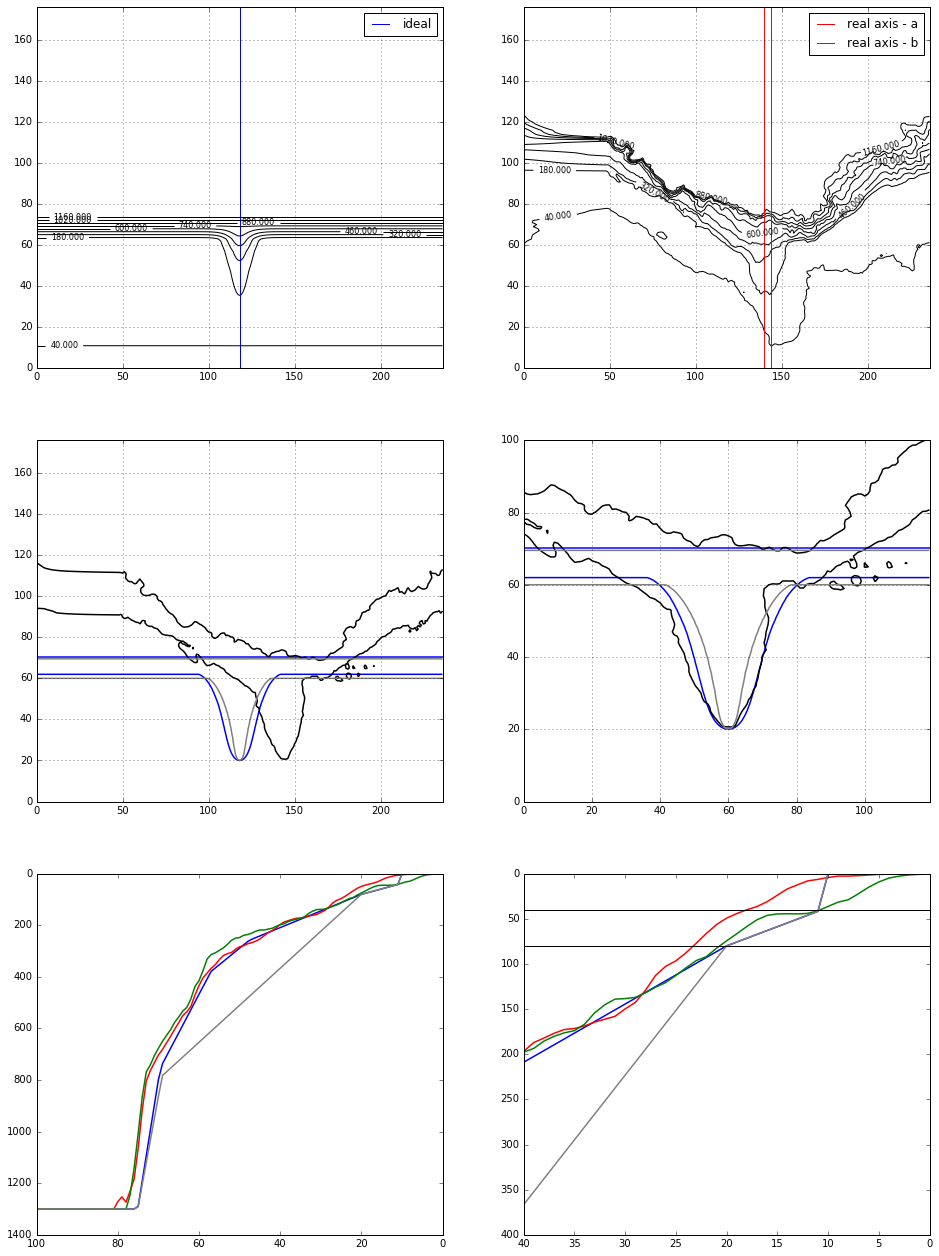

In [88]:
fig, ([ax1, ax2],[ax3, ax4], [ax5, ax6]) = plt.subplots(3, 2, figsize=(16,22))


levels = np.linspace(40, fluid_depth, 10)

c1 = ax1.contour(z_ideal, levels = levels, colors='k'); ax1.clabel(c1, inline=1, fontsize=8)
mid_ideal = int(z_ideal.shape[1]/2); ax1.axvline(mid_ideal, label='ideal')
ax1.grid(); ax1.legend()

c1 = ax2.contour(z_real, levels = levels, colors='k'); ax2.clabel(c1, inline=1, fontsize=8)
mid_reala = 140; ax2.axvline(mid_reala, c='r', label='real axis - a')
mid_realb = 144; ax2.axvline(mid_realb, c='g', label = 'real axis - b')
ax2.grid(); ax2.legend()
    
cs = ['b', 'r', 'g', 'gray']
zs = [z_ideal, z_real, z_real, z_ideal_orig]
mids = [mid_ideal, mid_reala, mid_realb, mid_ideal]
for z, i, c in zip(zs, mids, cs):
    ax5.plot(np.arange(z.shape[0]), z[:, i], c=c, lw=1.5)
    ax6.plot(np.arange(z.shape[0]), z[:, i], c=c, lw=1.5)

levels = [80, fluid_depth - z_paral]
cs = ['b', 'k', 'gray']
zs = [z_ideal, z_real, z_ideal_orig]
mids = [mid_ideal, mid_realb, mid_ideal, mid_ideal]
for z, i, c in zip(zs, mids, cs):
    ax3.contour(z, levels, colors=c, linewidths=1.5)
    ax4.contour(z[:, i-60:i+60], levels, colors=c, linewidths=1.5)

ax3.grid()
ax4.set_ylim([0,100]); ax4.grid()
ax5.invert_yaxis(); ax5.set_xlim([100,0])
ax6.set_ylim([400,0]); ax6.set_xlim([40,0])
ax6.axhline(80, c='k'); ax6.axhline(40, c='k')